In [7]:
# импорт необходимых библеотек
from matplotlib import pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import math
import re
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

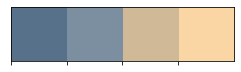

In [19]:
# задание палитры цветов
colors = ['#567189', '#7B8FA1', '#CFB997', '#FAD6A5']
sns.palplot(sns.color_palette(colors))

In [20]:
import matplotlib.colors as mcolors


def make_colormap(seq):
    
    """ функция создания пользовательского
            масштабируемого цвета """
    
    seq = [(None,) * 3, 0.0] + list(seq) + [1.0, (None,) * 3]
    cdict = {'red': [], 'green': [], 'blue': []}
    for i, item in enumerate(seq):
        if isinstance(item, float):
            r1, g1, b1 = seq[i - 1]
            r2, g2, b2 = seq[i + 1]
            cdict['red'].append([item, r1, r2])
            cdict['green'].append([item, g1, g2])
            cdict['blue'].append([item, b1, b2])
    return mcolors.LinearSegmentedColormap('CustomMap', cdict)

In [21]:
# задание палитры цветов
c = mcolors.ColorConverter().to_rgb
rvb = make_colormap(
    [c('slategray') , 0.25, c('slategray'), c('darkgray'), 0.50, \
     c('darkgray'), c('tan'), 0.75, c('tan'), c('wheat')])

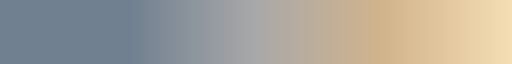

In [22]:
rvb

 ## Загрузка данных

In [2]:
# загрузка данных
df_sentiments = pd.read_csv('data/sentiments.csv')
df_sentiments.head()

,data_name,label_name,rating,review
0,train,pos,8,"I do try not to take IMDb ratings to heart, bu..."
1,train,pos,8,"I saw this when it first came to video, my lit..."
2,train,pos,10,its great i loved it ha cause i love dinosaurs...
3,train,pos,7,"I wouldn't call ""We're Back! A Dinosaur's Stor..."
4,train,pos,10,this was a personal favorite of mine when i wa...


In [3]:
# кодирование меток данных
label = {'pos' : 1, 'neg' : 0, 'unsup': -1}

In [4]:
# преобразование 
df_sentiments['label_name'] = df_sentiments['label_name'].map(label)

## Очистка текстовых данных

In [8]:
# функция очистки текстовых данных 
def preprocessor(text):
    # очистка текста от html разметки
    text = re.sub('<[^>]+>', '', text)
    # сохранение символов эмоций (или эмограммы)
    emoticons = re.findall('(?::|;|=)(?:-)?(?:\)|\(|D|P)', text)
    # очистка текста от всех не словарных символов, преобразование текста в строчные буквы
    text = re.sub('[\W]+', ' ', text.lower()) +\
        ' '.join(emoticons).replace('-', '')
    return text

In [9]:
%%time
# применение функции к комментариям (отзывам)
df_sentiments['review_clean'] = df_sentiments['review'].apply(preprocessor)

CPU times: total: 3.92 s
Wall time: 3.92 s


In [10]:
# вывод данных
df_sentiments.head()

,data_name,label_name,rating,review,review_clean
0,train,1,8,"I do try not to take IMDb ratings to heart, bu...",i do try not to take imdb ratings to heart but...
1,train,1,8,"I saw this when it first came to video, my lit...",i saw this when it first came to video my litt...
2,train,1,10,its great i loved it ha cause i love dinosaurs...,its great i loved it ha cause i love dinosaurs...
3,train,1,7,"I wouldn't call ""We're Back! A Dinosaur's Stor...",i wouldn t call we re back a dinosaur s story ...
4,train,1,10,this was a personal favorite of mine when i wa...,this was a personal favorite of mine when i wa...


## Создание признаков

In [11]:
from textblob import TextBlob

In [12]:
# функция подсчета количества предложений в комментарии (отзыве)
def review_sentences(review):
    
    blob = TextBlob(review)
    
    return len(blob.sentences)

In [14]:
# подсчет количества предложений в комментарии (отзыве)
df_sentiments['review_sentences'] = df_sentiments['review'].map(review_sentences)

In [15]:
# функция анализа комментария (отзыва)
def review_sentiment(review):
    
    blob = TextBlob(review)
    
    return blob.sentiment

In [16]:
# анализ комментария (отзыва)
df_sentiments['review_sentiment'] = df_sentiments['review_clean'].map(review_sentiment)

In [17]:
df_sentiments['review_polarity'] = df_sentiments['review_sentiment'].apply(lambda x: x.polarity)

In [18]:
df_sentiments['review_subjectivity'] = df_sentiments['review_sentiment'].apply(lambda x: x.subjectivity)

In [23]:
# рассчет корреляции в данных
sentiments_corr = df_sentiments.corr(method='spearman')
sentiments_corr

,label_name,rating,review_sentences,review_polarity,review_subjectivity
label_name,1.000000,0.875670,-0.045426,0.602219,0.008748
rating,0.875670,1.000000,-0.050198,0.616402,0.002613
review_sentences,-0.045426,-0.050198,1.000000,-0.076633,-0.051992
review_polarity,0.602219,0.616402,-0.076633,1.000000,0.036309
review_subjectivity,0.008748,0.002613,-0.051992,0.036309,1.000000


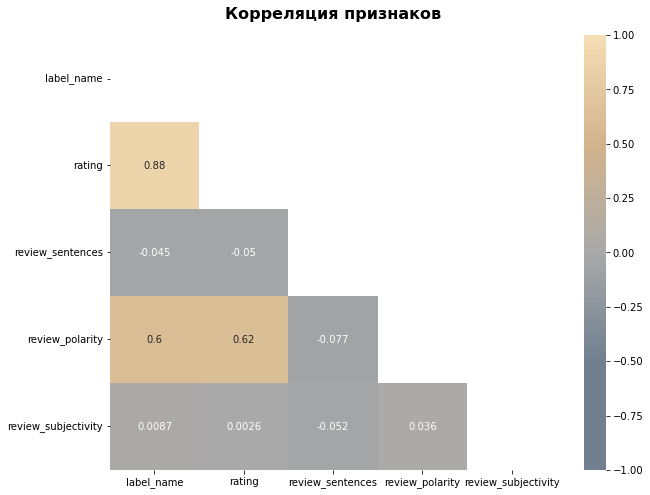

In [29]:
# визуализация корреляции признаков
plt.figure(figsize=(10, 8))
mask = np.triu(np.ones_like(sentiments_corr, dtype=bool))
df_train_corr_heatmap = sns.heatmap(sentiments_corr, mask=mask, vmin=-1, vmax=1, annot=True, cmap=rvb)
df_train_corr_heatmap.set_title('Корреляция признаков', fontweight='bold', \
                                fontdict={'fontsize':16}, pad=16)
plt.yticks(rotation=0)
plt.show()

## Формирование данных для обучения и теста модели

In [30]:
# данные для обучения
df_train = df_sentiments.query("data_name == 'train'")
df_train.head()

,data_name,label_name,rating,review,review_clean,review_sentences,review_sentiment,review_polarity,review_subjectivity
0,train,1,8,"I do try not to take IMDb ratings to heart, bu...",i do try not to take imdb ratings to heart but...,19,"(0.3390589569160997, 0.6550075585789873)",0.339059,0.655008
1,train,1,8,"I saw this when it first came to video, my lit...",i saw this when it first came to video my litt...,9,"(0.09246031746031746, 0.4793320105820105)",0.092460,0.479332
2,train,1,10,its great i loved it ha cause i love dinosaurs...,its great i loved it ha cause i love dinosaurs...,1,"(0.31616071428571424, 0.6617857142857144)",0.316161,0.661786
3,train,1,7,"I wouldn't call ""We're Back! A Dinosaur's Stor...",i wouldn t call we re back a dinosaur s story ...,10,"(0.2323529411764706, 0.4180672268907563)",0.232353,0.418067
4,train,1,10,this was a personal favorite of mine when i wa...,this was a personal favorite of mine when i wa...,5,"(0.1922916666666667, 0.5108333333333333)",0.192292,0.510833


In [31]:
# данные для теста
df_test = df_sentiments.query("data_name == 'test'")
df_test.head()

,data_name,label_name,rating,review,review_clean,review_sentences,review_sentiment,review_polarity,review_subjectivity
24708,test,1,8,"In this peculiar movie, the themes of the end ...",in this peculiar movie the themes of the end o...,4,"(0.1415633608815427, 0.6011707988980716)",0.141563,0.601171
24709,test,1,10,"In The Book of Life, Martin Donovan plays Jesu...",in the book of life martin donovan plays jesus...,17,"(0.12454771596562637, 0.5137316663436066)",0.124548,0.513732
24710,test,1,10,I saw this movie last night on HBO & didn't ex...,i saw this movie last night on hbo didn t expe...,4,"(0.01499999999999999, 0.2783333333333333)",0.015000,0.278333
24711,test,1,10,"No blood, no sex (though it oozes passion), no...",no blood no sex though it oozes passion no spe...,6,"(0.3456349206349207, 0.5206349206349207)",0.345635,0.520635
24712,test,1,10,"In The Book of Life, Martin Donovan plays Jesu...",in the book of life martin donovan plays jesus...,15,"(0.1328671328671328, 0.514154179154179)",0.132867,0.514154


In [32]:
df_train.columns

Index(['data_name', 'label_name', 'rating', 'review', 'review_clean',
       'review_sentences', 'review_sentiment', 'review_polarity',
       'review_subjectivity'],
      dtype='object')

In [51]:
column_num = ['review_sentences', 'review_polarity', 'review_subjectivity']
column_object = 'review_clean'

In [52]:
X_train = df_train[column_num + [column_object]]
X_train[:2]

,review_sentences,review_polarity,review_subjectivity,review_clean
0,19,0.339059,0.655008,i do try not to take imdb ratings to heart but...
1,9,0.092460,0.479332,i saw this when it first came to video my litt...


In [88]:
y_train = df_train['rating']
y_train[:2]

0    8
1    8
Name: rating, dtype: int64

In [53]:
X_test = df_test[column_num + [column_object]]
X_test[:2]

,review_sentences,review_polarity,review_subjectivity,review_clean
24708,4,0.141563,0.601171,in this peculiar movie the themes of the end o...
24709,17,0.124548,0.513732,in the book of life martin donovan plays jesus...


In [89]:
y_test = df_test['rating']
y_test[:2]

24708     8
24709    10
Name: rating, dtype: int64

# Мешок слов

Извлечение признаков из текстов: обычный подсчет количества употреблений слов в тексте. \
Для этого используем sklearn.feature_extraction.text.CountVectorizer. \
С использованием англиских стоп слов в его настройках.

In [37]:
from sklearn.feature_extraction.text import CountVectorizer

In [63]:
vectorizer = CountVectorizer(stop_words='english')

In [64]:
train_object_vector = vectorizer.fit_transform(X_train[column_object])

In [65]:
test_object_vector = vectorizer.transform(X_test[column_object])

In [66]:
train_object_vector.shape, test_object_vector.shape

((25000, 75596), (25000, 75596))

In [67]:
import scipy.sparse as sparse

In [68]:
train_num = X_train[column_num]
test_num = X_test[column_num]

In [103]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
train_num_ss = scaler.fit_transform(train_num)
test_num_ss = scaler.transform(test_num)

In [104]:
train_num_vector_ss = sparse.coo_matrix(train_num_ss)
test_num_vector_ss = sparse.coo_matrix(test_num_ss)

In [70]:
from scipy.sparse import hstack

In [105]:
X_train_vector_ss = hstack((train_object_vector, train_num_vector_ss))

In [106]:
X_test_vector_ss = hstack((test_object_vector, test_num_vector_ss))

In [107]:
X_train_vector_ss.shape, X_test_vector_ss.shape

((25000, 75599), (25000, 75599))

In [ ]:
Будем использовать классифиактор для мультиклассифкации [sklearn.naive_bayes.MultinomialNB]().

- Проведите кроссвалидацию на 5 фолдах для метрики `accuracy`.
- обучите на тренировочных данных, 
- нарисуйте красивую confusion матрицу, (с именами классов, а не индексами по осям)
- выведите отчет классификации для тестовой выборки (с именами классов, а не индексами)

In [221]:
from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB()

In [222]:
from sklearn.model_selection import cross_val_score

In [223]:
cv = cross_val_score(clf, train_object_vector, y_train, cv=5, scoring='accuracy')

In [224]:
cv

array([0.3706, 0.3524, 0.3542, 0.3574, 0.3616])

In [225]:
clf.fit(train_object_vector, y_train)

MultinomialNB()

In [226]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [227]:
y_pred = clf.predict(train_object_vector).astype('int')

In [228]:
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

           1       0.59      0.97      0.73      5100
           2       0.96      0.43      0.60      2284
           3       0.91      0.58      0.71      2420
           4       0.85      0.67      0.75      2696
           7       0.83      0.64      0.72      2496
           8       0.78      0.64      0.70      3009
           9       0.91      0.47      0.62      2263
          10       0.67      0.89      0.76      4732

    accuracy                           0.72     25000
   macro avg       0.81      0.66      0.70     25000
weighted avg       0.77      0.72      0.71     25000



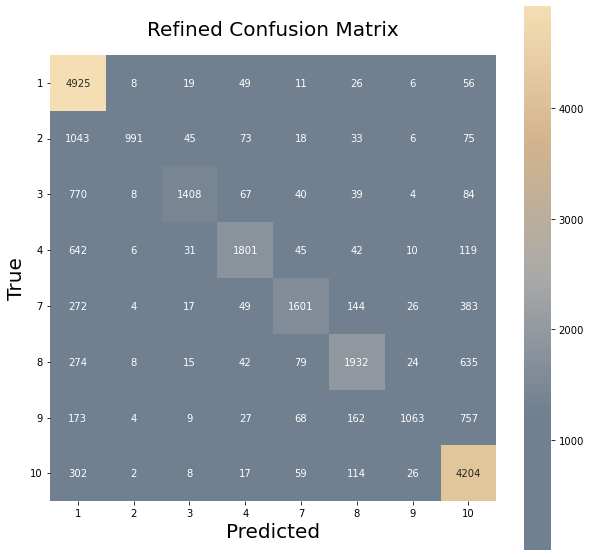

In [229]:
plt.figure(figsize=(10,10)) 
_ = sns.heatmap(confusion_matrix(y_train, y_pred), xticklabels=[1, 2, 3, 4, 7, 8, 9, 10], \
                yticklabels=[1, 2, 3, 4, 7, 8, 9, 10], cmap=rvb, fmt='g', square=True, annot=True)
plt.title('Refined Confusion Matrix', fontsize=20, pad=20)
plt.xlabel('Predicted', fontsize=20)
plt.ylabel('True', fontsize=20)
plt.yticks(rotation=0)
plt.show()

In [230]:
y_pred_test = clf.predict(test_object_vector).astype('int')

In [231]:
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           1       0.42      0.86      0.56      5022
           2       0.19      0.02      0.03      2302
           3       0.21      0.08      0.11      2541
           4       0.27      0.23      0.25      2635
           7       0.26      0.15      0.19      2307
           8       0.25      0.22      0.24      2850
           9       0.18      0.03      0.05      2344
          10       0.47      0.67      0.56      4999

    accuracy                           0.38     25000
   macro avg       0.28      0.28      0.25     25000
weighted avg       0.32      0.38      0.31     25000



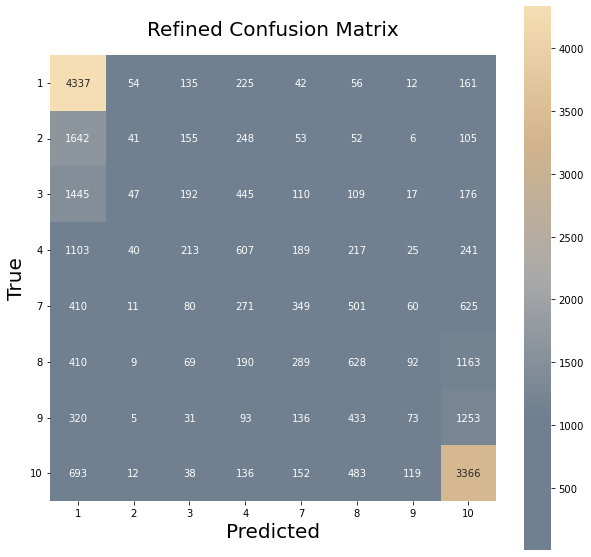

In [232]:
plt.figure(figsize=(10,10)) 
_ = sns.heatmap(confusion_matrix(y_test, y_pred_test), xticklabels=[1, 2, 3, 4, 7, 8, 9, 10], \
                yticklabels=[1, 2, 3, 4, 7, 8, 9, 10], cmap=rvb, fmt='g', square=True, annot=True)
plt.title('Refined Confusion Matrix', fontsize=20, pad=20)
plt.xlabel('Predicted', fontsize=20)
plt.ylabel('True', fontsize=20)
plt.yticks(rotation=0)
plt.show()

In [129]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [282]:
vectorizer = TfidfVectorizer(ngram_range=(1, 2), stop_words='english', max_features=1000)

In [283]:
X_train_object_tfdf = vectorizer.fit_transform(X_train[column_object])

In [284]:
X_test_object_tfdf = vectorizer.transform(X_test[column_object])

In [285]:
X_train_object_tfdf.shape, X_test_object_tfdf.shape

((25000, 1000), (25000, 1000))

In [286]:
X_train_vector_tfdf_ss = hstack((X_train_object_tfdf, train_num_vector_ss))

In [287]:
X_test_vector_tfdf_ss = hstack((X_test_object_tfdf, test_num_vector_ss))

In [288]:
clf = MultinomialNB()

In [289]:
cv = cross_val_score(clf, X_train_object_tfdf, y_train, cv=5, scoring='accuracy')

In [290]:
cv

array([0.3834, 0.3736, 0.3776, 0.3718, 0.3782])

In [167]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

In [244]:
%%time
# кросс-валидация на 5 фолдах и вывод метрик
logit = LogisticRegression(random_state=0)
logit_grid_searcher = GridSearchCV(estimator=logit, param_grid={'C':[0.7, 1.0, 2.0, 5.0],
                                                                    'penalty' : ['l1', 'l2', 'elasticnet'],
                                                                    'solver': ['lbfgs', 'liblinear'],
                                                                    'max_iter':[40, 50, 70, 100]},
                                       scoring='accuracy', n_jobs=-1, cv=5)
logit_grid_searcher.fit(X_train_vector_tfdf_ss, y_train)
logit_grid_searcher.best_score_

CPU times: total: 4min 20s
Wall time: 3h 15min 43s


0.40532

In [245]:
logit_grid_searcher.best_params_

{'C': 5.0, 'max_iter': 70, 'penalty': 'l2', 'solver': 'lbfgs'}

In [246]:
y_pred = logit_grid_searcher.best_estimator_.predict(X_train_vector_tfdf_ss)

In [247]:
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

           1       0.90      0.98      0.94      5100
           2       0.98      0.90      0.94      2284
           3       0.97      0.93      0.95      2420
           4       0.97      0.94      0.95      2696
           7       0.96      0.93      0.94      2496
           8       0.96      0.95      0.96      3009
           9       0.99      0.91      0.95      2263
          10       0.92      0.96      0.94      4732

    accuracy                           0.94     25000
   macro avg       0.96      0.94      0.95     25000
weighted avg       0.95      0.94      0.94     25000



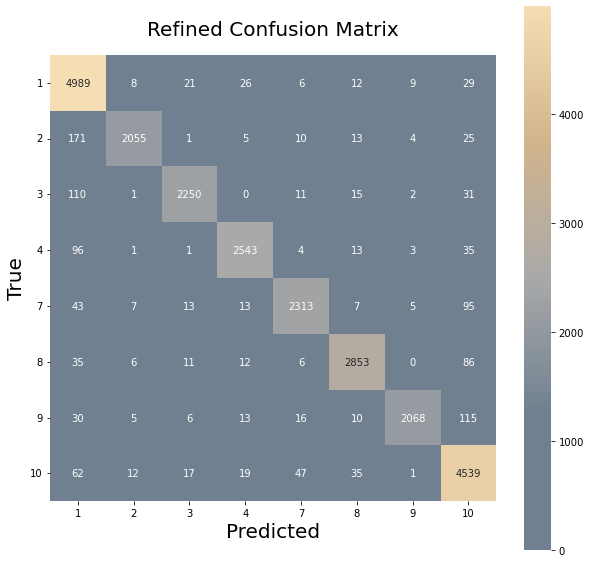

In [248]:
plt.figure(figsize=(10,10)) 
_ = sns.heatmap(confusion_matrix(y_train, y_pred), xticklabels=[1, 2, 3, 4, 7, 8, 9, 10], \
                yticklabels=[1, 2, 3, 4, 7, 8, 9, 10], cmap=rvb, fmt='g', square=True, annot=True)
plt.title('Refined Confusion Matrix', fontsize=20, pad=20)
plt.xlabel('Predicted', fontsize=20)
plt.ylabel('True', fontsize=20)
plt.yticks(rotation=0)
plt.show()

In [249]:
y_pred_test = logit_grid_searcher.best_estimator_.predict(X_test_vector_tfdf_ss).astype('int')

In [250]:
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           1       0.54      0.79      0.64      5022
           2       0.21      0.09      0.12      2302
           3       0.25      0.16      0.20      2541
           4       0.30      0.32      0.31      2635
           7       0.28      0.29      0.29      2307
           8       0.26      0.28      0.27      2850
           9       0.23      0.07      0.11      2344
          10       0.54      0.67      0.60      4999

    accuracy                           0.42     25000
   macro avg       0.33      0.33      0.32     25000
weighted avg       0.37      0.42      0.38     25000



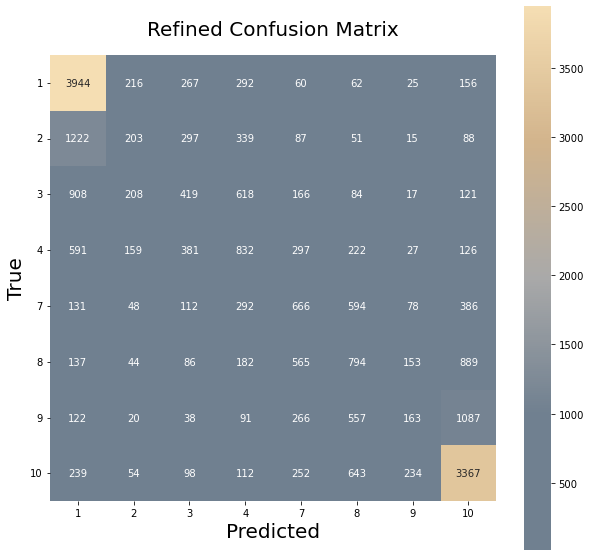

In [252]:
plt.figure(figsize=(10,10)) 
_ = sns.heatmap(confusion_matrix(y_test, y_pred_test), xticklabels=[1, 2, 3, 4, 7, 8, 9, 10], \
                yticklabels=[1, 2, 3, 4, 7, 8, 9, 10], cmap=rvb, fmt='g', square=True, annot=True)
plt.title('Refined Confusion Matrix', fontsize=20, pad=20)
plt.xlabel('Predicted', fontsize=20)
plt.ylabel('True', fontsize=20)
plt.yticks(rotation=0)
plt.show()

In [291]:
from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier(n_neighbors=5, weights='uniform')

In [292]:
neigh.fit(X_train_vector_tfdf_ss, y_train)

KNeighborsClassifier()

In [293]:
y_pred = neigh.predict(X_train_vector_tfdf_ss)

In [294]:
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

           1       0.50      0.83      0.63      5100
           2       0.44      0.34      0.38      2284
           3       0.47      0.33      0.39      2420
           4       0.51      0.36      0.42      2696
           7       0.47      0.41      0.44      2496
           8       0.49      0.43      0.46      3009
           9       0.48      0.32      0.39      2263
          10       0.58      0.59      0.58      4732

    accuracy                           0.51     25000
   macro avg       0.49      0.45      0.46     25000
weighted avg       0.50      0.51      0.49     25000



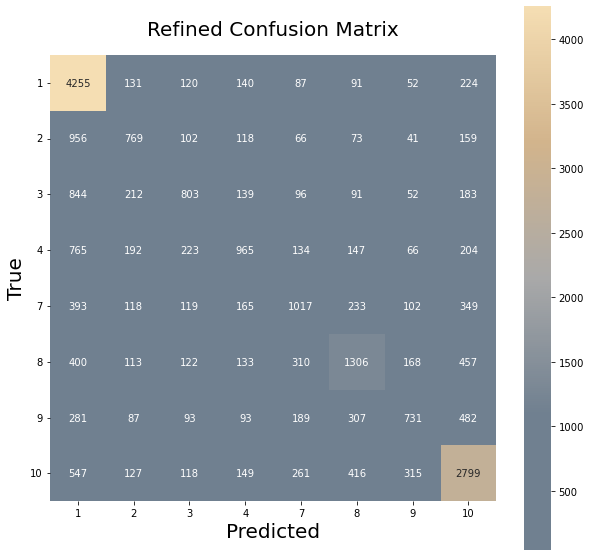

In [295]:
plt.figure(figsize=(10,10)) 
_ = sns.heatmap(confusion_matrix(y_train, y_pred), xticklabels=[1, 2, 3, 4, 7, 8, 9, 10], \
                yticklabels=[1, 2, 3, 4, 7, 8, 9, 10], cmap=rvb, fmt='g', square=True, annot=True)
plt.title('Refined Confusion Matrix', fontsize=20, pad=20)
plt.xlabel('Predicted', fontsize=20)
plt.ylabel('True', fontsize=20)
plt.yticks(rotation=0)
plt.show()

In [296]:
y_pred_test = neigh.predict(X_test_vector_tfdf_ss)

In [297]:
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           1       0.36      0.65      0.46      5022
           2       0.13      0.10      0.11      2302
           3       0.14      0.09      0.11      2541
           4       0.15      0.10      0.12      2635
           7       0.16      0.14      0.15      2307
           8       0.17      0.15      0.16      2850
           9       0.14      0.09      0.11      2344
          10       0.38      0.36      0.37      4999

    accuracy                           0.27     25000
   macro avg       0.20      0.21      0.20     25000
weighted avg       0.24      0.27      0.24     25000



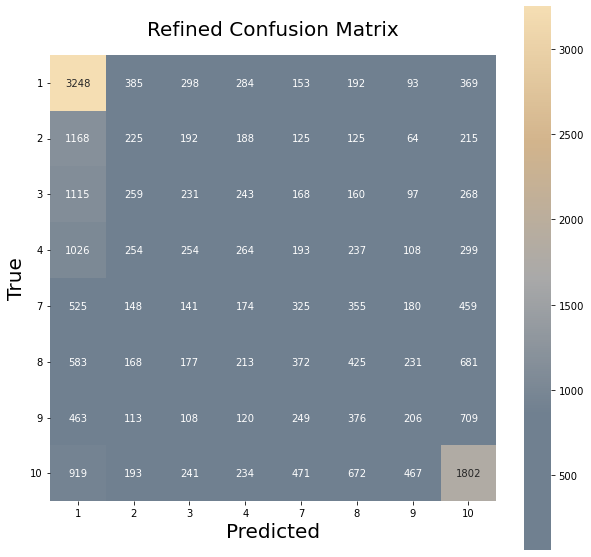

In [298]:
plt.figure(figsize=(10,10)) 
_ = sns.heatmap(confusion_matrix(y_test, y_pred_test), xticklabels=[1, 2, 3, 4, 7, 8, 9, 10], \
                yticklabels=[1, 2, 3, 4, 7, 8, 9, 10], cmap=rvb, fmt='g', square=True, annot=True)
plt.title('Refined Confusion Matrix', fontsize=20, pad=20)
plt.xlabel('Predicted', fontsize=20)
plt.ylabel('True', fontsize=20)
plt.yticks(rotation=0)
plt.show()

In [299]:
from sklearn.ensemble import RandomForestClassifier

In [300]:
clf = RandomForestClassifier(n_estimators=100, max_depth=7, random_state=0)

In [301]:
clf.fit(X_train_vector_tfdf_ss, y_train)

RandomForestClassifier(max_depth=7, random_state=0)

In [302]:
y_pred = neigh.predict(X_train_vector_tfdf_ss)

In [303]:
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

           1       0.50      0.83      0.63      5100
           2       0.44      0.34      0.38      2284
           3       0.47      0.33      0.39      2420
           4       0.51      0.36      0.42      2696
           7       0.47      0.41      0.44      2496
           8       0.49      0.43      0.46      3009
           9       0.48      0.32      0.39      2263
          10       0.58      0.59      0.58      4732

    accuracy                           0.51     25000
   macro avg       0.49      0.45      0.46     25000
weighted avg       0.50      0.51      0.49     25000



In [304]:
from catboost import CatBoostClassifier, Pool

In [305]:
model = CatBoostClassifier(loss_function='MultiClass')

In [306]:
train_dataset = Pool(X_train_vector_tfdf_ss.toarray(), y_train)

In [307]:
model.fit(train_dataset, verbose=True, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.093243
0:	learn: 2.0255170	total: 921ms	remaining: 15m 20s
1:	learn: 1.9855394	total: 1.8s	remaining: 14m 57s
2:	learn: 1.9567553	total: 2.64s	remaining: 14m 37s
3:	learn: 1.9317969	total: 3.49s	remaining: 14m 28s
4:	learn: 1.9071326	total: 4.34s	remaining: 14m 24s
5:	learn: 1.8879221	total: 5.21s	remaining: 14m 22s
6:	learn: 1.8704710	total: 6.02s	remaining: 14m 14s
7:	learn: 1.8540093	total: 6.88s	remaining: 14m 13s
8:	learn: 1.8418118	total: 7.74s	remaining: 14m 12s
9:	learn: 1.8306596	total: 8.58s	remaining: 14m 9s
10:	learn: 1.8223163	total: 9.43s	remaining: 14m 7s
11:	learn: 1.8124773	total: 10.2s	remaining: 14m 3s
12:	learn: 1.8041656	total: 11.1s	remaining: 14m
13:	learn: 1.7960493	total: 11.9s	remaining: 13m 57s
14:	learn: 1.7896613	total: 12.7s	remaining: 13m 57s
15:	learn: 1.7834946	total: 13.6s	remaining: 13m 54s
16:	learn: 1.7792297	total: 14.4s	remaining: 13m 52s
17:	learn: 1.7748786	total: 15.2s	remaining: 13m 50s
18:	learn: 1.7708347	total: 16s	re

154:	learn: 1.5621828	total: 2m 5s	remaining: 11m 25s
155:	learn: 1.5612122	total: 2m 6s	remaining: 11m 24s
156:	learn: 1.5601514	total: 2m 7s	remaining: 11m 23s
157:	learn: 1.5590706	total: 2m 8s	remaining: 11m 22s
158:	learn: 1.5580261	total: 2m 8s	remaining: 11m 21s
159:	learn: 1.5572406	total: 2m 9s	remaining: 11m 20s
160:	learn: 1.5563091	total: 2m 10s	remaining: 11m 20s
161:	learn: 1.5553453	total: 2m 11s	remaining: 11m 19s
162:	learn: 1.5546249	total: 2m 12s	remaining: 11m 18s
163:	learn: 1.5538270	total: 2m 12s	remaining: 11m 17s
164:	learn: 1.5529827	total: 2m 13s	remaining: 11m 17s
165:	learn: 1.5520832	total: 2m 14s	remaining: 11m 16s
166:	learn: 1.5510778	total: 2m 15s	remaining: 11m 15s
167:	learn: 1.5499471	total: 2m 16s	remaining: 11m 15s
168:	learn: 1.5490118	total: 2m 17s	remaining: 11m 14s
169:	learn: 1.5483385	total: 2m 18s	remaining: 11m 14s
170:	learn: 1.5471791	total: 2m 18s	remaining: 11m 13s
171:	learn: 1.5466876	total: 2m 19s	remaining: 11m 12s
172:	learn: 1.54

305:	learn: 1.4579823	total: 4m 7s	remaining: 9m 21s
306:	learn: 1.4577656	total: 4m 8s	remaining: 9m 20s
307:	learn: 1.4569949	total: 4m 9s	remaining: 9m 19s
308:	learn: 1.4565976	total: 4m 9s	remaining: 9m 18s
309:	learn: 1.4559287	total: 4m 10s	remaining: 9m 17s
310:	learn: 1.4554246	total: 4m 11s	remaining: 9m 17s
311:	learn: 1.4549829	total: 4m 12s	remaining: 9m 16s
312:	learn: 1.4545705	total: 4m 13s	remaining: 9m 15s
313:	learn: 1.4541228	total: 4m 13s	remaining: 9m 14s
314:	learn: 1.4534300	total: 4m 14s	remaining: 9m 13s
315:	learn: 1.4528186	total: 4m 15s	remaining: 9m 12s
316:	learn: 1.4524704	total: 4m 16s	remaining: 9m 11s
317:	learn: 1.4519098	total: 4m 16s	remaining: 9m 11s
318:	learn: 1.4516014	total: 4m 17s	remaining: 9m 10s
319:	learn: 1.4512517	total: 4m 18s	remaining: 9m 9s
320:	learn: 1.4509263	total: 4m 19s	remaining: 9m 8s
321:	learn: 1.4506424	total: 4m 20s	remaining: 9m 7s
322:	learn: 1.4501961	total: 4m 20s	remaining: 9m 6s
323:	learn: 1.4496821	total: 4m 21s	

458:	learn: 1.3922554	total: 6m 11s	remaining: 7m 17s
459:	learn: 1.3918030	total: 6m 11s	remaining: 7m 16s
460:	learn: 1.3916149	total: 6m 12s	remaining: 7m 15s
461:	learn: 1.3911947	total: 6m 13s	remaining: 7m 14s
462:	learn: 1.3907978	total: 6m 14s	remaining: 7m 14s
463:	learn: 1.3906192	total: 6m 15s	remaining: 7m 13s
464:	learn: 1.3902983	total: 6m 15s	remaining: 7m 12s
465:	learn: 1.3899295	total: 6m 16s	remaining: 7m 11s
466:	learn: 1.3895552	total: 6m 17s	remaining: 7m 10s
467:	learn: 1.3891450	total: 6m 18s	remaining: 7m 10s
468:	learn: 1.3888779	total: 6m 19s	remaining: 7m 9s
469:	learn: 1.3886825	total: 6m 19s	remaining: 7m 8s
470:	learn: 1.3883777	total: 6m 20s	remaining: 7m 7s
471:	learn: 1.3880636	total: 6m 21s	remaining: 7m 6s
472:	learn: 1.3876510	total: 6m 22s	remaining: 7m 5s
473:	learn: 1.3871697	total: 6m 22s	remaining: 7m 4s
474:	learn: 1.3867793	total: 6m 23s	remaining: 7m 4s
475:	learn: 1.3862940	total: 6m 24s	remaining: 7m 3s
476:	learn: 1.3860145	total: 6m 25s	

611:	learn: 1.3422628	total: 8m 16s	remaining: 5m 14s
612:	learn: 1.3418956	total: 8m 16s	remaining: 5m 13s
613:	learn: 1.3417514	total: 8m 17s	remaining: 5m 12s
614:	learn: 1.3414623	total: 8m 18s	remaining: 5m 12s
615:	learn: 1.3412769	total: 8m 19s	remaining: 5m 11s
616:	learn: 1.3409308	total: 8m 20s	remaining: 5m 10s
617:	learn: 1.3406607	total: 8m 21s	remaining: 5m 9s
618:	learn: 1.3403263	total: 8m 21s	remaining: 5m 8s
619:	learn: 1.3399747	total: 8m 22s	remaining: 5m 8s
620:	learn: 1.3395886	total: 8m 23s	remaining: 5m 7s
621:	learn: 1.3392133	total: 8m 24s	remaining: 5m 6s
622:	learn: 1.3390070	total: 8m 25s	remaining: 5m 5s
623:	learn: 1.3388625	total: 8m 26s	remaining: 5m 4s
624:	learn: 1.3385642	total: 8m 26s	remaining: 5m 4s
625:	learn: 1.3381581	total: 8m 27s	remaining: 5m 3s
626:	learn: 1.3379652	total: 8m 28s	remaining: 5m 2s
627:	learn: 1.3374988	total: 8m 29s	remaining: 5m 1s
628:	learn: 1.3372482	total: 8m 30s	remaining: 5m
629:	learn: 1.3368767	total: 8m 31s	remaini

764:	learn: 1.2992275	total: 10m 19s	remaining: 3m 10s
765:	learn: 1.2990494	total: 10m 20s	remaining: 3m 9s
766:	learn: 1.2989168	total: 10m 21s	remaining: 3m 8s
767:	learn: 1.2986862	total: 10m 22s	remaining: 3m 7s
768:	learn: 1.2982647	total: 10m 22s	remaining: 3m 7s
769:	learn: 1.2979938	total: 10m 23s	remaining: 3m 6s
770:	learn: 1.2977805	total: 10m 24s	remaining: 3m 5s
771:	learn: 1.2976513	total: 10m 25s	remaining: 3m 4s
772:	learn: 1.2975074	total: 10m 26s	remaining: 3m 3s
773:	learn: 1.2969989	total: 10m 26s	remaining: 3m 3s
774:	learn: 1.2967515	total: 10m 27s	remaining: 3m 2s
775:	learn: 1.2964391	total: 10m 28s	remaining: 3m 1s
776:	learn: 1.2962638	total: 10m 29s	remaining: 3m
777:	learn: 1.2960927	total: 10m 30s	remaining: 2m 59s
778:	learn: 1.2960512	total: 10m 30s	remaining: 2m 58s
779:	learn: 1.2956982	total: 10m 31s	remaining: 2m 58s
780:	learn: 1.2954360	total: 10m 32s	remaining: 2m 57s
781:	learn: 1.2950893	total: 10m 33s	remaining: 2m 56s
782:	learn: 1.2949013	tot

915:	learn: 1.2637922	total: 12m 18s	remaining: 1m 7s
916:	learn: 1.2636805	total: 12m 19s	remaining: 1m 6s
917:	learn: 1.2635700	total: 12m 20s	remaining: 1m 6s
918:	learn: 1.2633419	total: 12m 20s	remaining: 1m 5s
919:	learn: 1.2631173	total: 12m 21s	remaining: 1m 4s
920:	learn: 1.2628058	total: 12m 22s	remaining: 1m 3s
921:	learn: 1.2623944	total: 12m 23s	remaining: 1m 2s
922:	learn: 1.2623308	total: 12m 24s	remaining: 1m 2s
923:	learn: 1.2621607	total: 12m 24s	remaining: 1m 1s
924:	learn: 1.2618636	total: 12m 25s	remaining: 1m
925:	learn: 1.2617580	total: 12m 26s	remaining: 59.6s
926:	learn: 1.2615914	total: 12m 27s	remaining: 58.8s
927:	learn: 1.2613159	total: 12m 27s	remaining: 58s
928:	learn: 1.2610788	total: 12m 28s	remaining: 57.2s
929:	learn: 1.2608871	total: 12m 29s	remaining: 56.4s
930:	learn: 1.2606901	total: 12m 30s	remaining: 55.6s
931:	learn: 1.2605232	total: 12m 31s	remaining: 54.8s
932:	learn: 1.2602332	total: 12m 31s	remaining: 54s
933:	learn: 1.2599912	total: 12m 32

In [308]:
preds = model.predict(X_test_vector_tfdf_ss.toarray())

In [309]:
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           1       0.49      0.80      0.61      5022
           2       0.20      0.03      0.05      2302
           3       0.27      0.11      0.15      2541
           4       0.29      0.30      0.29      2635
           7       0.29      0.22      0.25      2307
           8       0.26      0.21      0.23      2850
           9       0.26      0.03      0.06      2344
          10       0.46      0.76      0.57      4999

    accuracy                           0.41     25000
   macro avg       0.31      0.31      0.28     25000
weighted avg       0.35      0.41      0.34     25000

